## 基于mindspore实现语义分割案例

本实验主要介绍使用MindSpore深度学习框架在PASCAL VOC格式的数据集上实现Deeplabv3网络模型并完成语义分割及测试。

## 1、实验目的

- 掌握如何使用Mindspore深度学习框架构建deeplabv3网络模型。
- 了解如何使用Mindspore准备数据集以及预训练相关模型。 
- 了解如何使用Mindspore加载预训练模型并完成预测。

## 2、语义分割算法原理介绍

语义分割是基于像素点级别的物体识别问题。目标是用对应的所表示的类来标记图像的每个像素。因为我们正在预测图像中的每个像素，所以此任务通常被称为密集预测。

语义分割有着广泛的应用场景，包括自动驾驶，人机交互，医学图像诊断，计算摄影学和增强现实等。

- 语义分割网络介绍

一般的语义分割架构可以被认为是一个编码器-解码器网络。编码器通常是一个预训练的分类网络，像 VGG、ResNet，然后是一个解码器网络。这些架构不同的地方主要在于解码器网络。解码器的任务是将编码器学习到的可判别特征（较低分辨率）从语义上投影到像素空间（较高分辨率），以获得密集分类。语义分割不仅需要在像素级有判别能力，还需要有能将编码器在不同阶段学到的可判别特征投影到像素空间的机制。不同的架构采用不同的机制（跳跃连接、金字塔池化等）作为解码机制的一部分。

- Deeplab网络介绍
近来，深度卷积网络（DCNN）在高级视觉任务（图像分类和目标检测）中展示了优异的性能。

- Deeplabv1结合DCNN 和概率图模型来解决像素级分类任务（即语义分割）。其关键特点：

1.提出空洞卷积（atrous convolution）。<br>
2.在最后两个最大池化操作中不降低特征图的分辨率，并在倒数第二个最大池化之后的卷积中使用空洞卷积。

3.使用 CRF（条件随机场） 作为后处理，恢复边界细节，达到准确定位效果。

4.附加输入图像和前四个最大池化层的每个输出到一个两层卷积，然后拼接到主网络的最后一层，达到 多尺度预测效果。

- Deeplabv3关键特点：

1.强调上采样过滤器的卷积，或“空洞卷积”，在密集预测任务中是一个强大的工具。空洞卷积允许显式地控制在深度卷积神经网络中计算的特征响应的分辨率。它还允许有效地扩大过滤器的视野，在不增加参数数量或计算量的情况下引入更大的上下文。

2.提出了一种空洞空间金字塔池化（ASPP）的多尺度鲁棒分割方法。ASPP 使用多个采样率的过滤器和有效的视野探测传入的卷积特征层，从而在多个尺度上捕获目标和图像上下文。
![avatar](fig/fig7.png)

3.结合 DCNNs 方法和概率图形模型，改进了目标边界的定位。DCNNs 中常用的最大池化和下采样的组合实现了不变性，但对定位精度有一定的影响。通过将 DCNN 最后一层的响应与一个全连接条件随机场(CRF)相结合来克服这个问题。

- Deeplabv3相较于之前的Deeplab有很大的改进，在Pascal VOC 2012图像语义分割基准上获得了state-of-art的性能,参考论文[《Rethinking Atrous Convolution for Semantic Image Segmentation
》](http://arxiv.org/abs/1706.05587)。 其关键特点：

1.为了解决多尺度目标的分割问题，串行/并行设计了能够捕捉多尺度上下文的模块，模块中采用不同的空洞率。

2.增强了先前提出的空洞空间金字塔池化（ASPP）模块，增加了图像级特征来编码全局上下文，使得模块可以在多尺度下探测卷积特征。并在没有 CRF 作为后处理的情况下显著提升了性能。

![avatar](fig/fig1.jpg)

### 3 实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=MindSpore 2.0；Python环境=3.7


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|


## 4、数据处理

## 4.1数据准备

PASCAL VOC挑战赛 （The PASCAL Visual Object Classes ）是一个世界级的计算机视觉挑战赛，在2005年-2012年举办。
PASCAL VOC挑战赛主要包括以下几类：

图像分类(Object Classification)\
目标检测(Object Detection)\
目标分割(Object Segmentation)\
行为识别(Action Classification) 等。\
voc数据集是该项比赛公布使用的数据集，在2012版本中，共拥有17000张图片及相对应的标注，供参赛者使用以完成相关的挑战。
在Pascal VOC数据集中主要包含20个目标类别，下图展示了所有类别的名称以及所属超类。
![avatar](fig/fig4.png)

数据集内容如下所示:
![avatar](fig/fig6.jpg)

本次实验采用voc2012数据集切割后的 miniVOC数据集，共有58张图片及相应的标注。

数据格式如下：

/seg2\
├── JPEG\
&emsp;├──xxxxxxx.jpg\
&emsp;└──xxxxxxx2.jpg\
├──MASK1\
&emsp;├──xxxxxx.png\
&emsp;└──xxxxxx2.jpg\
├──train.txt\
└──val.txt

## 4.2数据加载
使用预先处理好的voc格式数据集，将其保存在项目的根目录下。

## 4.3 导入python库
在代码最开始集中导入整个实验中所需要使用的库和函数。

In [1]:
# 导入依赖库
# os库
import os
# 引入numpy
import numpy as np
# 引入读写不同数据文件格式的函数
import scipy.io
# 引入数据序列化和反序列化
import pickle
# 引入操作图像方法
from PIL import Image
# 引入高级的文件,文件夹,压缩包处理模块
import shutil
# 引入计算机视觉库
import cv2
# 引入归一化提供训练测试所用的数据集
from mindspore.mindrecord import FileWriter
# 引入数据读取
import mindspore.dataset as de
# 引入MindSpore
import mindspore as ms
# 引入神经网络模块
import mindspore.nn as nn
#导入mindspore中的ops模块
import mindspore.ops  as P
# 引入张量模块
from mindspore import Tensor
from mindspore import load_checkpoint
from mindspore import load_param_into_net
from mindspore import dtype as mstype
# 引入python解释器和它的环境有关的函数
import sys
# 将字典转为easydict
from easydict import EasyDict as edict
# 引入模型训练或推理的高阶接口。
# 引入用于构建Callback函数基类。
from mindspore.train import ModelCheckpoint, CheckpointConfig,LossMonitor, TimeMonitor,Model
# 引入集合通信接口
from mindspore.communication import init, get_rank, get_group_size
# 引入用于构建Callback函数的基类。
from mindspore import amp
from mindspore import set_seed
import PIL
# 引入绘图模块
import matplotlib.pyplot as plt
# 引入可视化库
import matplotlib as mpl
# 引入可视化库色彩模块
import matplotlib.colors as colors
# import moxing as mox

## 4.4 数据预处理
构建一个数据集分割类，通过该类生成Mindrecord文件，实现预处理数据集等操作。

In [2]:
# 设置Opencv的线程数量为0
cv2.setNumThreads(0)
# 数据集对象，用于载入语义分割数据集
class SegDataset:
    def __init__(self,
                 image_mean,# 图像像素值平均值
                 image_std,# 图像像素值标准差
                 data_file='',# 数据集文件路径
                 batch_size=32,# 单次训练所使用样本的数量
                 crop_size=512,# 随机裁剪后的图片大小
                 max_scale=2.0,# 最大缩放比例
                 min_scale=0.5,# 最小缩放比例
                 ignore_label=255,# 忽略标签值
                 num_classes=21,# 图像和标签中的类别数量
                 num_readers=2,# 读取数据的IO线程数量
                 num_parallel_calls=4,# 数据集batch的并行度
                 shard_id=None, # 数据集分片ID，None表示无分片
                 shard_num=None# 数据集分片数量，None表示无分片
                               ):
        # 定义数据集文件路径
        self.data_file = data_file
        # 定义单次训练所使用样本的数量
        self.batch_size = batch_size
        # 定义随机裁剪后的图片大小
        self.crop_size = crop_size
        # 定义图像像素值平均值
        self.image_mean = np.array(image_mean, dtype=np.float32)
        # 定义图像像素值标准差
        self.image_std = np.array(image_std, dtype=np.float32)
        # 定义最大缩放比例
        self.max_scale = max_scale
        # 定义最小缩放比例
        self.min_scale = min_scale
        # 定义忽略标签值
        self.ignore_label = ignore_label
        # 定义图像和标签中的类别数量
        self.num_classes = num_classes
        # 定义读取数据的IO线程数量
        self.num_readers = num_readers
        # 定义数据集batch的并行度
        self.num_parallel_calls = num_parallel_calls
        # 定义数据集分片ID
        self.shard_id = shard_id
        # 定义数据集分片数量
        self.shard_num = shard_num
        # VOC数据集原始图片文件夹路径
        self.voc_img_dir = os.path.join(self.data_file,'JPEG')
        # VOC数据集语义标注图片文件夹路径
        self.voc_anno_dir = os.path.join(self.data_file,'MASK1')
        # VOC数据集训练集文件列表路径
        self.voc_train_lst = os.path.join(self.data_file,'train.txt')
        # VOC数据集验证集文件列表路径
        self.voc_val_lst = os.path.join(self.data_file,'val.txt')
        #  VOC数据集使用的灰度标注图片文件夹路径
        self.voc_anno_gray_dir = os.path.join(self.data_file,'SegmentationClassGray')
        # 生成的MindRecord文件保存路径
        self.mindrecord_save =  os.path.join(self.data_file,'VOC_mindrecord')
        # 最大缩放比例必须大于最小缩放比例                               
        assert max_scale > min_scale
    #数据预处理，包括图像的解码，尺度缩放，随机裁剪等操作
    def preprocess_(self, image, label):
        #bgr图像解码
        image_out = cv2.imdecode(np.frombuffer(image, dtype=np.uint8), cv2.IMREAD_COLOR)
        #灰度图像解码
        label_out = cv2.imdecode(np.frombuffer(label, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        #尺度缩放
        sc = np.random.uniform(self.min_scale, self.max_scale)
        new_h, new_w = int(sc * image_out.shape[0]), int(sc * image_out.shape[1])
        image_out = cv2.resize(image_out, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        label_out = cv2.resize(label_out, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        #图像标准化
        image_out = (image_out - self.image_mean) / self.image_std
        #随机裁剪
        h_, w_ = max(new_h, self.crop_size), max(new_w, self.crop_size)
        pad_h, pad_w = h_ - new_h, w_ - new_w
        if pad_h > 0 or pad_w > 0:
            image_out = cv2.copyMakeBorder(image_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
            label_out = cv2.copyMakeBorder(label_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=self.ignore_label)
        offset_h = np.random.randint(0, h_ - self.crop_size + 1)
        offset_w = np.random.randint(0, w_ - self.crop_size + 1)
        image_out = image_out[offset_h: offset_h + self.crop_size, offset_w: offset_w + self.crop_size, :]
        label_out = label_out[offset_h: offset_h + self.crop_size, offset_w: offset_w+self.crop_size]
        #随机水平翻转
        if np.random.uniform(0.0, 1.0) > 0.5:
            image_out = image_out[:, ::-1, :]
            label_out = label_out[:, ::-1]
        #图像转置以符合模型输入要求
        image_out = image_out.transpose((2, 0, 1))
        image_out = image_out.copy()
        label_out = label_out.copy()
        return image_out, label_out

    #得到灰度数据集的方法，若文件已存在，则直接返回
    def get_gray_dataset(self):
        if os.path.exists(self.voc_anno_gray_dir):
            print('the gray file is already exists！')
            return
        os.makedirs(self.voc_anno_gray_dir)

        #转换彩色图像为灰度图像，并保存到指定路径
        print('converting voc color png to gray png ...')
        for ann in os.listdir(self.voc_anno_dir):
            ann_im = Image.open(os.path.join(self.voc_anno_dir, ann))
            #将该图像转换为灰度图像
            ann_im = Image.fromarray(np.array(ann_im))
            ann_im.save(os.path.join(self.voc_anno_gray_dir, ann))
        print('converting done')
    #获取MindRecord格式的数据集，num_shards为生成MindRecord的分片数，shuffle为是否对数据做洗牌处理    
    def get_mindrecord_dataset(self, is_training,num_shards=1, shuffle=True):
        datas = []
        if is_training:
            data_lst = self.voc_train_lst
            self.mindrecord_save = os.path.join(self.mindrecord_save,'train')
        else:
            data_lst = self.voc_val_lst
            self.mindrecord_save = os.path.join(self.mindrecord_save,'eval')
        
        if os.path.exists(self.mindrecord_save):
            #shutil.rmtree(self.mindrecord_save)
            print('mindrecord file is already exists！')
            self.mindrecord_save = os.path.join(self.mindrecord_save,'VOC_mindrecord')
            return
        
        with open(data_lst) as f:
            lines = f.readlines()
        if shuffle:
            np.random.shuffle(lines)
            
        print('creating mindrecord dataset...')
        os.makedirs(self.mindrecord_save)
        self.mindrecord_save = os.path.join(self.mindrecord_save,'VOC_mindrecord')
        print('number of samples:', len(lines))
        #定义MindRecord的schema
        seg_schema = {"file_name": {"type": "string"}, "label": {"type": "bytes"}, "data": {"type": "bytes"}}
        writer = FileWriter(file_name=self.mindrecord_save, shard_num=num_shards)
        writer.add_schema(seg_schema, "seg_schema")
        #将schema写入MindRecord
        cnt = 0
        for l in lines:
            id_ = l.strip()
            img_path = os.path.join(self.voc_img_dir, id_ + '.jpg')
            label_path = os.path.join(self.voc_anno_gray_dir, id_ + '.png')
            
            sample_ = {"file_name": img_path.split('/')[-1]}
            with open(img_path, 'rb') as f:
                sample_['data'] = f.read()
            with open(label_path, 'rb') as f:
                sample_['label'] = f.read()
            datas.append(sample_)
            cnt += 1
            if cnt % 1000 == 0:
                writer.write_raw_data(datas)
                print('number of samples written:', cnt)
                datas = []

        if datas:
            writer.write_raw_data(datas)
        writer.commit()
        print('number of samples written:', cnt)
        print('Create Mindrecord Done')
    #生成文件    
    def get_dataset(self, repeat=1):
        data_set = de.MindDataset(dataset_files=self.mindrecord_save, columns_list=["data", "label"],
                                  shuffle=True, num_parallel_workers=self.num_readers,
                                  num_shards=self.shard_num, shard_id=self.shard_id)
        transforms_list = self.preprocess_
        data_set = data_set.map(operations=transforms_list, input_columns=["data", "label"],
                                output_columns=["data", "label"],
                                num_parallel_workers=self.num_parallel_calls)
        data_set = data_set.shuffle(buffer_size=self.batch_size * 10)
        data_set = data_set.batch(self.batch_size, drop_remainder=True)
        data_set = data_set.repeat(repeat)
        return data_set

# 5. 实验过程
## 5.1 模型构建
利用mindspore框架提供的相关函数完成Deeplabv3主体网络的构建，\
通过定义多个resnet cell结构组成整体的Deeplabv3网络。\
最终的网络是以类的方式进行定义，通过实例化即可创建对应的网络对象。

In [3]:
# 定义1x1卷积层
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, weight_init='xavier_uniform')

# 定义3x3卷积层
def conv3x3(in_planes, out_planes, stride=1, dilation=1, padding=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, pad_mode='pad', padding=padding,
                     dilation=dilation, weight_init='xavier_uniform')

#定义Resnet主体网络
class Resnet(nn.Cell):
    def __init__(self, block, block_num, output_stride, use_batch_statistics=True):
        super(Resnet, self).__init__()
        self.inplanes = 64# 输入通道数
        # 第一层卷积层
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, pad_mode='pad', padding=3,
                               weight_init='xavier_uniform')
        self.bn1 = nn.BatchNorm2d(self.inplanes, use_batch_statistics=use_batch_statistics)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 第一层残差块
        self.layer1 = self._make_layer(block, 64, block_num[0], use_batch_statistics=use_batch_statistics)
        # 第二层残差块
        self.layer2 = self._make_layer(block, 128, block_num[1], stride=2, use_batch_statistics=use_batch_statistics)
        # 根据输出步长选择第三、第四层残差块
        if output_stride == 16:
            self.layer3 = self._make_layer(block, 256, block_num[2], stride=2,
                                           use_batch_statistics=use_batch_statistics)
            self.layer4 = self._make_layer(block, 512, block_num[3], stride=1, base_dilation=2, grids=[1, 2, 4],
                                           use_batch_statistics=use_batch_statistics)
        elif output_stride == 8:
            self.layer3 = self._make_layer(block, 256, block_num[2], stride=1, base_dilation=2,
                                           use_batch_statistics=use_batch_statistics)
            self.layer4 = self._make_layer(block, 512, block_num[3], stride=1, base_dilation=4, grids=[1, 2, 4],
                                           use_batch_statistics=use_batch_statistics)
    # 构建残差块
    def _make_layer(self, block, planes, blocks, stride=1, base_dilation=1, grids=None, use_batch_statistics=True):
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.SequentialCell([
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion, use_batch_statistics=use_batch_statistics)
            ])

        if grids is None:
            grids = [1] * blocks

        layers = [
            block(self.inplanes, planes, stride, downsample, dilation=base_dilation * grids[0],
                  use_batch_statistics=use_batch_statistics)
        ]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(
                block(self.inplanes, planes, dilation=base_dilation * grids[i],
                      use_batch_statistics=use_batch_statistics))

        return nn.SequentialCell(layers)
    # 前向推理
    def construct(self, x):
        out = self.conv1(x)# 第一层卷积
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)# 第一层池化
        out = self.layer1(out)  # 第一层残差块
        out = self.layer2(out)  # 第二层残差块
        out = self.layer3(out)  # 第三层残差块
        out = self.layer4(out)  # 第四层残差块

        return out

#构建Bottleneck，用于ResNeXt中构建残差块
class Bottleneck(nn.Cell):
    # 扩充率为4
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1, use_batch_statistics=True):
        super(Bottleneck, self).__init__()
        # 第一个1x1卷积层
        self.conv1 = conv1x1(inplanes, planes)
        # 第一个BatchNorm层
        self.bn1 = nn.BatchNorm2d(planes, use_batch_statistics=use_batch_statistics)
        # 第二个3x3卷积层
        self.conv2 = conv3x3(planes, planes, stride, dilation, dilation)
        # 第二个BatchNorm层
        self.bn2 = nn.BatchNorm2d(planes, use_batch_statistics=use_batch_statistics)
        # 第三个1x1卷积层，维度扩充
        self.conv3 = conv1x1(planes, planes * self.expansion)
        # 第三个BatchNorm层
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, use_batch_statistics=use_batch_statistics)
        # Relu激活函数
        self.relu = nn.ReLU()
        # 下采样层，使维度匹配
        self.downsample = downsample
        # 张量相加操作
        self.add = P.Add()

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        # 将identity和out相加
        out = self.add(out, identity)
        out = self.relu(out)
        return out

#构建ASPP，用于DeepLabV3+中的ASPP模块
class ASPP(nn.Cell):
    def __init__(self, atrous_rates, phase='train', in_channels=2048, num_classes=21,
                 use_batch_statistics=True):
        super(ASPP, self).__init__()
        # 训练或者测试阶段
        self.phase = phase
        # 输出通道数
        out_channels = 256
        # ASPP卷积层1
        self.aspp1 = ASPPConv(in_channels, out_channels, atrous_rates[0], use_batch_statistics=use_batch_statistics)
         # ASPP卷积层2
        self.aspp2 = ASPPConv(in_channels, out_channels, atrous_rates[1], use_batch_statistics=use_batch_statistics)
         # ASPP卷积层3
        self.aspp3 = ASPPConv(in_channels, out_channels, atrous_rates[2], use_batch_statistics=use_batch_statistics)
         # ASPP卷积层4
        self.aspp4 = ASPPConv(in_channels, out_channels, atrous_rates[3], use_batch_statistics=use_batch_statistics)
        # ASPP池化层
        self.aspp_pooling = ASPPPooling(in_channels, out_channels)
        # 输出通道数为(out_channels * (len(atrous_rates) + 1))
        self.conv1 = nn.Conv2d(out_channels * (len(atrous_rates) + 1), out_channels, kernel_size=1,
                               weight_init='xavier_uniform')
        # BatchNorm层
        self.bn1 = nn.BatchNorm2d(out_channels, use_batch_statistics=use_batch_statistics)
        # Relu激活函数
        self.relu = nn.ReLU()
        # 输出通道数为num_classes
        self.conv2 = nn.Conv2d(out_channels, num_classes, kernel_size=1, weight_init='xavier_uniform', has_bias=True)
        # 沿着通道维度拼接
        self.concat = P.Concat(axis=1)
        # 随机失活，防止过拟合
        self.drop = nn.Dropout(p=0.3)

    def construct(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.aspp_pooling(x)

        x = self.concat((x1, x2))
        x = self.concat((x, x3))
        x = self.concat((x, x4))
        x = self.concat((x, x5))

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # 如果是训练阶段，则进行随机失活
        if self.phase == 'train':
            x = self.drop(x)
        x = self.conv2(x)
        return x

##定义ASPPPooling类，用于定义ASPP池操作
class ASPPPooling(nn.Cell):
    #定义参数
    def __init__(self, in_channels, out_channels, use_batch_statistics=True):
        super(ASPPPooling, self).__init__()
        #定义卷积层操作
        self.conv = nn.SequentialCell([
            #1x1卷积操作
            nn.Conv2d(in_channels, out_channels, kernel_size=1, weight_init='xavier_uniform'),
            #批量归一化操作
            nn.BatchNorm2d(out_channels, use_batch_statistics=use_batch_statistics),
            #激活函数操作
            nn.ReLU()
        ])
        #定义shape操作
        self.shape = P.Shape()

    def construct(self, x):
        #获取输入x的大小
        size = self.shape(x)
        #先对输入x进行全局平均池化操作
        out = nn.AvgPool2d(size[2])(x)
        #再进行卷积、批量归一化、激活操作
        out = self.conv(out)
        #大小变化为输入x的大小
        out = P.ResizeNearestNeighbor((size[2], size[3]), True)(out)
        return out

#定义ASPPConv类，用于定义ASPP卷积操作
class ASPPConv(nn.Cell):
    #定义参数
    def __init__(self, in_channels, out_channels, atrous_rate=1, use_batch_statistics=True):
        super(ASPPConv, self).__init__()
        #根据不同的空洞卷积率定义不同的卷积操作
        if atrous_rate == 1:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, has_bias=False, weight_init='xavier_uniform')
        else:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, pad_mode='pad', padding=atrous_rate,
                             dilation=atrous_rate, weight_init='xavier_uniform')
        #批量归一化操作
        bn = nn.BatchNorm2d(out_channels, use_batch_statistics=use_batch_statistics)
        #激活函数操作
        relu = nn.ReLU()
        #定义卷积层操作
        self.aspp_conv = nn.SequentialCell([conv, bn, relu])

    def construct(self, x):
        #进行卷积、批量归一化、激活操作
        out = self.aspp_conv(x)
        return out

#定义DeepLabV3类，用于定义整个DeepLabV3网络
class DeepLabV3(nn.Cell):
    def __init__(self, phase='train', num_classes=21, output_stride=16, freeze_bn=False):
        super(DeepLabV3, self).__init__()
        #根据输入的参数freeze_bn来判断是否使用批量归一化操作
        use_batch_statistics = not freeze_bn
        #调用Resnet类来构建ResNet网络
        self.resnet = Resnet(Bottleneck, [3, 4, 23, 3], output_stride=output_stride,
                             use_batch_statistics=use_batch_statistics)
        #调用ASPP类来构建ASPP网络
        self.aspp = ASPP([1, 6, 12, 18], phase, 2048, num_classes,
                         use_batch_statistics=use_batch_statistics)
        #定义shape操作
        self.shape = P.Shape()

    def construct(self, x):
        #获取输入x的大小
        size = self.shape(x)
        #将输入x输入到ResNet网络中，得到输出
        out = self.resnet(x)
        #将ResNet的输出输入到ASPP网络中，得到ASPP的输出
        out = self.aspp(out)
        #将ASPP的输出进行大小变换，变成与输入x相同的大小
        out = P.ResizeBilinear((size[2], size[3]), True)(out)
        return out

定义不同的学习率函数。

In [4]:
#定义不同的学习率
#生成cosine学习率下降序列
def cosine_lr(base_lr, decay_steps, total_steps):
    for i in range(int(total_steps)):
        step_ = min(i, decay_steps)
        yield base_lr * 0.5 * (1 + np.cos(np.pi * step_ / decay_steps))

#生成polynomial学习率下降序列
def poly_lr(base_lr, decay_steps, total_steps, end_lr=0.0001, power=0.9):
    for i in range(int(total_steps)):
        step_ = min(i, decay_steps)
        yield (base_lr - end_lr) * ((1.0 - step_ / decay_steps) ** power) + end_lr

#生成exponential学习率下降序列
def exponential_lr(base_lr, decay_steps, decay_rate, total_steps, staircase=False):
    for i in range(total_steps):
        if staircase:
            power_ = i // decay_steps
        else:
            power_ = float(i) / decay_steps
        yield base_lr * (decay_rate ** power_)

定义损失函数。

In [5]:
#定义损失函数
class SoftmaxCrossEntropyLoss(nn.Cell):
    def __init__(self, num_cls=21, ignore_label=255):
        super(SoftmaxCrossEntropyLoss, self).__init__()
        #one-hot编码相关操作
        self.one_hot = P.OneHot(axis=-1)
        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)
        #类型转换相关操作
        self.cast = P.Cast()
        #softmax交叉熵损失函数及相关操作
        self.ce = nn.SoftmaxCrossEntropyWithLogits()
        #类别数及忽略标签
        self.not_equal = P.NotEqual()
        self.num_cls = num_cls
        self.ignore_label = ignore_label
        #矩阵乘法及求和相关操作
        self.mul = P.Mul()
        self.sum = P.ReduceSum(False)
        self.div = P.RealDiv()
        #转置及形状变换相关操作
        self.transpose = P.Transpose()
        self.reshape = P.Reshape()
    #将标签转换为整形
    def construct(self, logits, labels):
        #将标签拉成一维并转换形状
        labels_int = self.cast(labels, mstype.int32)
        labels_int = self.reshape(labels_int, (-1,))
         #将logits转置并转换形状
        logits_ = self.transpose(logits, (0, 2, 3, 1))
        logits_ = self.reshape(logits_, (-1, self.num_cls))
         #生成权重
        weights = self.not_equal(labels_int, self.ignore_label)
        weights = self.cast(weights, mstype.float32)
        #生成one-hot标签
        one_hot_labels = self.one_hot(labels_int, self.num_cls, self.on_value, self.off_value)
        #计算softmax交叉熵损失
        loss = self.ce(logits_, one_hot_labels)
         #加权
        loss = self.mul(weights, loss)
        #求平均损失
        loss = self.div(self.sum(loss), self.sum(weights))
        return loss

# 6、模型训练
## 6.1 构建训练函数
利用mindspore中相关的函数加载预训练的模型，并构建训练网络的类。

In [6]:
# 设置随机种子
set_seed(1)
# 设置上下文
ms.set_context(mode=ms.GRAPH_MODE, save_graphs=False,
                    device_target="CPU")
# 建立训练网络
class BuildTrainNetwork(nn.Cell):
    def __init__(self, network, criterion):
        super(BuildTrainNetwork, self).__init__()
        self.network = network
        self.criterion = criterion

    def construct(self, input_data, label):
        output = self.network(input_data)
        net_loss = self.criterion(output, label)
        return net_loss
# 训练函数
def train(args):
    # 如果使用分布式训练，则初始化
    if args.is_distributed:
        init()
        args.rank = get_rank()
        args.group_size = get_group_size()

        parallel_mode = ParallelMode.DATA_PARALLEL
        ms.set_auto_parallel_context(parallel_mode=parallel_mode, gradients_mean=True, device_num=args.group_size)
    
    
    # 构建数据集
    dataset = SegDataset(image_mean=args.image_mean,
                                        image_std=args.image_std,
                                        data_file=args.data_file,
                                        batch_size=args.batch_size,
                                        crop_size=args.crop_size,
                                        max_scale=args.max_scale,
                                        min_scale=args.min_scale,
                                        ignore_label=args.ignore_label,
                                        num_classes=args.num_classes,
                                        num_readers=2,
                                        num_parallel_calls=4,
                                        shard_id=args.rank,
                                        shard_num=args.group_size)
    dataset.get_gray_dataset()
    dataset.get_mindrecord_dataset(is_training=True)
    dataset = dataset.get_dataset(repeat=1)
    

    # 构建相关网络
    if args.model == 'deeplab_v3_s16':
        network = DeepLabV3('train', args.num_classes, 16, args.freeze_bn)
    elif args.model == 'deeplab_v3_s8':
        network = DeepLabV3('train', args.num_classes, 8, args.freeze_bn)
    else:
        raise NotImplementedError('model [{:s}] not recognized'.format(args.model))

    # 构建损失函数
    loss_ = SoftmaxCrossEntropyLoss(args.num_classes, args.ignore_label)
    loss_.add_flags_recursive(fp32=True)
    train_net = BuildTrainNetwork(network, loss_)

    # l加载预训练模型
    param_dict = ms.load_checkpoint(args.ckpt_file)
    ms.load_param_into_net(train_net, param_dict)

    # 优化器
    iters_per_epoch = dataset.get_dataset_size()
    total_train_steps = iters_per_epoch * args.train_epochs
    if args.lr_type == 'cos':
        lr_iter = cosine_lr(args.base_lr, total_train_steps, total_train_steps)
    elif args.lr_type == 'poly':
        lr_iter = poly_lr(args.base_lr, total_train_steps, total_train_steps, end_lr=0.0, power=0.9)
    elif args.lr_type == 'exp':
        lr_iter = exponential_lr(args.base_lr, args.lr_decay_step, args.lr_decay_rate,
                                                total_train_steps, staircase=True)
    else:
        raise ValueError('unknown learning rate type')
    opt = nn.Momentum(params=train_net.trainable_params(), learning_rate=lr_iter, momentum=0.9, weight_decay=0.0001,
                      loss_scale=args.loss_scale)

    # 损失梯度缩放
    manager_loss_scale = amp.FixedLossScaleManager(args.loss_scale, drop_overflow_update=False)
    model = Model(train_net, optimizer=opt, amp_level="O3", loss_scale_manager=manager_loss_scale)

    # 回调函数，用于保存 ckpts
    time_cb = TimeMonitor(data_size=iters_per_epoch)
    loss_cb = LossMonitor()
    cbs = [time_cb, loss_cb]

    if args.rank == 0:
        config_ck = CheckpointConfig(save_checkpoint_steps=iters_per_epoch,
                                     keep_checkpoint_max=args.keep_checkpoint_max)
        ckpoint_cb = ModelCheckpoint(prefix=args.model, directory=args.train_dir, config=config_ck)
        cbs.append(ckpoint_cb)
    # 开始训练
    model.train(args.train_epochs, dataset, callbacks=cbs,dataset_sink_mode=True)

## 6.2 模型训练
使用之前构建好的训练函数，完成对模型的训练。

其中预加载的模型是使用voc2012完整数据集训练完成的，为方便演示，本层所使用的数据集为voc裁剪以后的小型数据集，约60张图片。

In [7]:
##设定相关参数并转为edict对象
cfg = edict({
    "batch_size": 16,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],#图片均值
    "image_std": [57.375, 57.120, 58.395],#图片标准差
    "min_scale": 0.5, #最小缩放比例
    "max_scale": 2.0, #最大缩放比例
    "ignore_label": 255, #忽略标签
    "num_classes": 21, #分类数
    "train_epochs" : 1, #训练轮数
    "lr_type": 'cos', #学习率变化方式
    "base_lr": 0.0, #基础学习率
    "lr_decay_step": 3*91, #学习率递减步数
    "lr_decay_rate" :0.1, #学习率递减率
    "loss_scale": 2048, #损失函数缩放比例
    "model": 'deeplab_v3_s8', #模型类型
    'rank': 0, #排名
    'group_size':1, #组大小
    'keep_checkpoint_max':1, #最大保存点数
    'train_dir': 'model', #训练目录
    'is_distributed':False, #是否分布式训练
    'freeze_bn':True #是否冻结BN层
})

#如果训练目录存在，则删除
if os.path.exists(cfg.train_dir):
    shutil.rmtree(cfg.train_dir)
#数据路径和checkpoint路径    
data_path = './seg2'

cfg.data_file = data_path

ckpt_path = './ckpt/deeplab_v3_s8-300_11.ckpt'

cfg.ckpt_file = ckpt_path
#开始训练模型
train(cfg)

the gray file is already exists！
mindrecord file is already exists！
epoch: 1 step: 1, loss is 0.04775945097208023
epoch: 1 step: 2, loss is 4.443418502807617
epoch: 1 step: 3, loss is 5.822732925415039
Train epoch time: 978400.988 ms, per step time: 326133.663 ms


## 7、模型预测

## 7.1、构建预测模块
利用mindspore库以及之前定义好的函数，构建用于模型预测相关的功能。

In [8]:
#设置MindSpore的模式为图模式，设备类型为CPU
ms.set_context(mode=ms.GRAPH_MODE, device_target="CPU", save_graphs=False)

#计算直方图
def cal_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(np.int32) + b[k], minlength=n ** 2).reshape(n, n)

#长边缩放函数
def resize_long(img, long_size=513):
    h, w, _ = img.shape
    if h > w:
        new_h = long_size
        new_w = int(1.0 * long_size * w / h)
    else:
        new_w = long_size
        new_h = int(1.0 * long_size * h / w)
    imo = cv2.resize(img, (new_w, new_h))
    return imo

#构建评估网络
class BuildEvalNetwork(nn.Cell):
    def __init__(self, network):
        super(BuildEvalNetwork, self).__init__()
        self.network = network
        self.softmax = nn.Softmax(axis=1)

    def construct(self, input_data):
        output = self.network(input_data)
        output = self.softmax(output)
        return output

#预处理函数
def pre_process(args, img_, crop_size=513):
    # resize
    img_ = resize_long(img_, crop_size)
    resize_h, resize_w, _ = img_.shape

    # mean, std
    image_mean = np.array(args.image_mean)
    image_std = np.array(args.image_std)
    img_ = (img_ - image_mean) / image_std

    # pad to crop_size
    pad_h = crop_size - img_.shape[0]
    pad_w = crop_size - img_.shape[1]
    if pad_h > 0 or pad_w > 0:
        img_ = cv2.copyMakeBorder(img_, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)

    # hwc to chw
    img_ = img_.transpose((2, 0, 1))
    return img_, resize_h, resize_w

# 定义了一个函数eval_batch，用于在输入一张或多张图像时，评估模型的输出值参数args为命令行参数，eval_net为评估用网络，img_lst为输入图像的列表，crop_size为裁剪后的大小，默认为513flip为是否对图像进行镜像翻转，默认为True
def eval_batch(args, eval_net, img_lst, crop_size=513, flip=True):
    # 初始化结果列表
    result_lst = []
    # 获取batch_size
    batch_size = len(img_lst)
    # 初始化batch_img矩阵，尺寸为(batch_size, 3, crop_size, crop_size)
    batch_img = np.zeros((args.batch_size, 3, crop_size, crop_size), dtype=np.float32)
    # 初始化resize_hw列表，用于记录每张图片经过预处理后的尺寸
    resize_hw = []
    # 循环处理每张图片
    for l in range(batch_size):
        # 获取当前图片
        img_ = img_lst[l]
        # 对当前图片进行预处理，返回预处理后的图片，以及裁剪后的高度和宽度
        img_, resize_h, resize_w = pre_process(args, img_, crop_size)
        # 将预处理后的图片加入batch_img矩阵中
        batch_img[l] = img_
        # 将裁剪后的高度和宽度加入resize_hw列表中
        resize_hw.append([resize_h, resize_w])
    # 将batch_img矩阵以连续的方式存储
    batch_img = np.ascontiguousarray(batch_img)
    # 通过评估用网络（eval_net）对batch_img矩阵进行评估，得到输出结果net_out
    net_out = eval_net(Tensor(batch_img, mstype.float32))
    # 将输出结果转换为numpy数组
    net_out = net_out.asnumpy()
    # 如果flip为True，则对batch_img矩阵进行镜像翻转，并再次对翻转后的batch_img矩阵进行评估，将得到的结果加到net_out中  
    if flip:
        batch_img = batch_img[:, :, :, ::-1]
        net_out_flip = eval_net(Tensor(batch_img, mstype.float32))
        net_out += net_out_flip.asnumpy()[:, :, :, ::-1]
    # 循环处理每个batch
    for bs in range(batch_size):
        # 获取输出结果的概率值
        probs_ = net_out[bs][:, :resize_hw[bs][0], :resize_hw[bs][1]].transpose((1, 2, 0))
        # 获取原始图像的高度和宽度
        ori_h, ori_w = img_lst[bs].shape[0], img_lst[bs].shape[1]
        # 将概率值的尺寸调整为原始图像的尺寸
        probs_ = cv2.resize(probs_, (ori_w, ori_h))
        # 将处理后的结果加到结果列表中
        result_lst.append(probs_)
    # 返回结果列表
    return result_lst

#定义了一个函数eval_batch_scales，用于在输入一张或多张图像时，按照不同比例分别进行评估，并将结果加起来参数args为命令行参数，eval_net为评估用网络，img_lst为输入图像的列表，scales为不同比例的列表base_crop_size为基准裁剪尺寸，默认为513，flip为是否对图像进行镜像翻转，默认为True
def eval_batch_scales(args, eval_net, img_lst, scales,
                      base_crop_size=513, flip=True):
    # 根据比例列表计算不同尺寸的裁剪尺寸
    sizes_ = [int((base_crop_size - 1) * sc) + 1 for sc in scales]
    # 对第一个尺寸进行评估，并将结果加入probs_lst列表
    probs_lst = eval_batch(args, eval_net, img_lst, crop_size=sizes_[0], flip=flip)
    # 对其他尺寸进行评估，并将结果加到probs_lst中
    for crop_size_ in sizes_[1:]:
        probs_lst_tmp = eval_batch(args, eval_net, img_lst, crop_size=crop_size_, flip=flip)
        for pl, _ in enumerate(probs_lst):
            probs_lst[pl] += probs_lst_tmp[pl]

    result_msk = []
    for i in probs_lst:
        # 将评估得到的概率值转换为类别号，加入result_msk列表中
        result_msk.append(i.argmax(axis=2))
    # 返回结果列表
    return result_msk

# The color source: print(list(colors.cnames.keys()))
#print(list(colors.cnames.keys()))
num_class = {0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat',
             9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant',
             17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor', 21: 'edge'}

num_color = {0:'aliceblue', 1:'grey', 2:'red', 3:'green', 4:'darkorange', 5:'lime', 6:'bisque',
     7:'black', 8:'blanchedalmond', 9:'blue', 10:'blueviolet', 11:'brown', 12:'burlywood', 13:'cadetblue', 
     14:'darkorange', 15:'tan', 16:'darkviolet', 17:'cornflowerblue', 18:'yellow', 19:'crimson', 20:'darkcyan'}

color_dic = [num_color[k] for k in sorted(num_color.keys())]
bounds = list(range(21))
cmap = mpl.colors.ListedColormap(color_dic)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# 定义一个函数num_to_ClassAndColor，用于将类别号转换为颜色和类别名称
def num_to_ClassAndColor(num_list):
    # 初始化颜色列表和类别列表
    color_ = []
    class_ = []
    # 循环处理每个类别号
    for num in num_list:
        # 将类别号对应的颜色加入颜色列表中
        color_.append(num_class[num])
        # 将类别号对应的类别名称加入类别列表中
        class_.append(num_color[num])
    # 返回颜色列表和类别列表
    return color_,class_

定义函数net_eval，用于评估模型的输出值

In [ ]:

def net_eval(args):
    # 根据命令行参数和模型类型（args.model），创建评估用网络
    if args.model == 'deeplab_v3_s16':
        network = DeepLabV3('eval', args.num_classes, 16, args.freeze_bn)
    elif args.model == 'deeplab_v3_s8':
        network = DeepLabV3('eval', args.num_classes, 8, args.freeze_bn)
    else:
        raise NotImplementedError('model [{:s}] not recognized'.format(args.model))

    eval_net = BuildEvalNetwork(network)

    # 加载训练好的模型参数
    param_dict = load_checkpoint(args.ckpt_file)
    load_param_into_net(eval_net, param_dict)
    # 设置评估用网络为测试状态
    eval_net.set_train(False)
    
   # 读取数据列表
    with open(args.data_lst) as f:
        img_lst = f.readlines()
        
    # evaluate函数,初始化hist矩阵，大小为(args.num_classes, args.num_classes)初始化batch_img_lst和batch_msk_lstbi表示batch中的图片数量，image_num表示总共处理的图片数量

    hist = np.zeros((args.num_classes, args.num_classes))
    batch_img_lst = []
    batch_msk_lst = []
    bi = 0
    image_num = 0
    # 遍历img_lst中的每个id
    for i, line in enumerate(img_lst):
        id_ = line.strip()
        img_path = os.path.join(cfg.voc_img_dir, id_ + '.jpg')
        msk_path = os.path.join(cfg.voc_anno_gray_dir, id_ + '.png')
        # 读取图像和标签    
        img_ = cv2.imread(img_path)
        msk_ = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
        batch_img_lst.append(img_)
        batch_msk_lst.append(msk_)
        # 判断是否需要输出图片评估结果
        if args.if_png:
            # 对当前batch中的所有图片进行评估
            batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                          base_crop_size=args.crop_size, flip=args.flip)
             # 获取图像大小
            height ,weight = batch_res[0].shape
            # 将标签中的ignore_label设置为0
            batch_msk_lst[0][batch_msk_lst[0]==args.ignore_label] = 0
            # 绘制三张显示图像、预测结果和标签的子图
            plt.figure(figsize=(3 * weight/1024*10, 2 * height/1024*10))
            plt.subplot(1,3,1)
            image = Image.open(img_path)
            plt.imshow(image)
            
            plt.subplot(1,3,2)
            plt.imshow(image)
            plt.imshow(batch_res[0],alpha=0.8,interpolation='none', cmap=cmap, norm=norm)
            
            
            plt.subplot(1,3,3)
            plt.imshow(image)
            plt.imshow(batch_msk_lst[0],alpha=0.8,interpolation='none', cmap=cmap, norm=norm)
            plt.show()
            # 获取预测结果和真实标签中的唯一值
            prediction_num = np.unique(batch_res[0])
            real_num = np.unique(batch_msk_lst[0])
            # 获取预测结果和真实标签对应的颜色值和类别名
            prediction_color,prediction_class = num_to_ClassAndColor(prediction_num)
            print('prediction num:',prediction_num)
            print('prediction color:',prediction_color)
            print('prediction class:',prediction_class)
            real_color,real_class = num_to_ClassAndColor(real_num)
            print('groundtruth num:',real_num)
            print('groundtruth color:',real_color)
            print('groundtruth class:',real_class)
            # 清空batch_img_lst和batch_msk_lst，用于存储下一个batch的图像和标签
            batch_img_lst = []
            batch_msk_lst = []
            # 判断当前处理的图片数是否小于args.num_png
            if i < args.num_png-1:
                continue
            else:
                return
        # 如果当前batch已经存满，则对这些图片进行评估    
        bi += 1
        if bi == args.batch_size:
            batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                          base_crop_size=args.crop_size, flip=args.flip)
            # 计算当前batch的混淆矩阵，并将其累加到hist中
            for mi in range(args.batch_size):
                hist += cal_hist(batch_msk_lst[mi].flatten(), batch_res[mi].flatten(), args.num_classes)

            bi = 0
            batch_img_lst = []
            batch_msk_lst = []
            # 每处理100张图像，输出处理进度
            if (i+1)%100 == 0:
                print('processed {} images'.format(i+1))
        image_num = i
    # 如果batch中还有剩余的图片，则对其进行评估
    if bi > 0:
        batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                      base_crop_size=args.crop_size, flip=args.flip)
        # 计算当前batch的混淆矩阵，并将其累加到hist中
        for mi in range(bi):
            hist += cal_hist(batch_msk_lst[mi].flatten(), batch_res[mi].flatten(), args.num_classes)
        if (i+1) % 100 == 0:
            print('processed {} images'.format(image_num + 1))
    # 计算每个类别的IoU，求其平均值作为结果输出
    np.seterr(divide="ignore", invalid="ignore")
    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    print('mean IoU', np.nanmean(iu))

## 7.2、验证模型

利用刚才定义好的模型，从数据集读取图片进行网络验证，不显示图片。

In [9]:
# test  1
# 定义配置文件
cfg = edict({
    "batch_size": 1, # 批大小
    "crop_size": 513, # 图像裁剪大小
    "image_mean": [103.53, 116.28, 123.675], # RGB图像为3通道，定义图像RGB均值
    "image_std": [57.375, 57.120, 58.395], # RGB图像为3通道，定义图像RGB标准差
    "scales": [1.0], # 数据增强的尺度范围
    # [0.5,0.75,1.0,1.25,1.75]
    'flip': True, # 是否进行翻转
    'ignore_label': 255, # 忽略标签的像素值
    'num_classes':21, # 类别数，此处为PASCAL VOC数据集
    'model': 'deeplab_v3_s8', # 模型名称
    'freeze_bn': True, # BN冻结，是否使用BN层

    'if_png':False,        # 数据是否使用png格式
    'num_png':10           # 数据集中的png图像数量
})

# 数据集路径
data_path = './seg2'
# if not os.path.exists(data_path):
     #mox.file.copy_parallel(src_url="s3://share-course/dataset/voc2012_raw/", dst_url=data_path)
cfg.data_file = data_path

# 定义数据集
dataset = SegDataset(image_mean=cfg.image_mean,
                                    image_std=cfg.image_std,
                                    data_file=cfg.data_file)
# 获取灰度图像数据集
dataset.get_gray_dataset()
# 数据集的txt标签路径
cfg.data_lst = os.path.join(cfg.data_file,'val.txt')
# VOC数据集中的图像路径
cfg.voc_img_dir = os.path.join(cfg.data_file,'JPEG')
# VOC数据集中的标签图像路径
cfg.voc_anno_gray_dir = os.path.join(cfg.data_file,'SegmentationClassGray')

ckpt_path = './ckpt'
# if not os.path.exists(ckpt_path):
#     mox.file.copy_parallel(src_url="s3://yyq-3/DATA/code/deeplabv3/model", dst_url=ckpt_path)   #if yours model had saved
# 加载模型文件路径
cfg.ckpt_file = os.path.join(ckpt_path,'deeplab_v3_s8-300_11.ckpt')  
print('loading checkpoing:',cfg.ckpt_file)
# 模型验证评估
net_eval(cfg)

the gray file is already exists！
loading checkpoing: ./ckpt/deeplab_v3_s8-300_11.ckpt
mean IoU 0.02965209282566093


利用刚才定义好的模型，从数据集读取图片进行网络验证，显示图片及结果。

the gray file is already exists！
loading checkpoing: ./ckpt/deeplab_v3_s8-300_11.ckpt


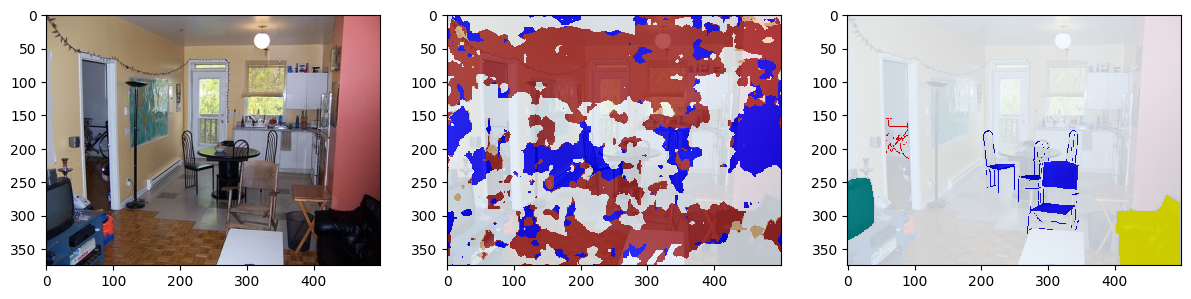

prediction num: [ 0  2  5  8  9 11 12 15]
prediction color: ['background', 'bicycle', 'bottle', 'cat', 'chair', 'diningtable', 'dog', 'person']
prediction class: ['aliceblue', 'red', 'lime', 'blanchedalmond', 'blue', 'brown', 'burlywood', 'tan']
groundtruth num: [ 0  2  9 18 20]
groundtruth color: ['background', 'bicycle', 'chair', 'sofa', 'tvmonitor']
groundtruth class: ['aliceblue', 'red', 'blue', 'yellow', 'darkcyan']


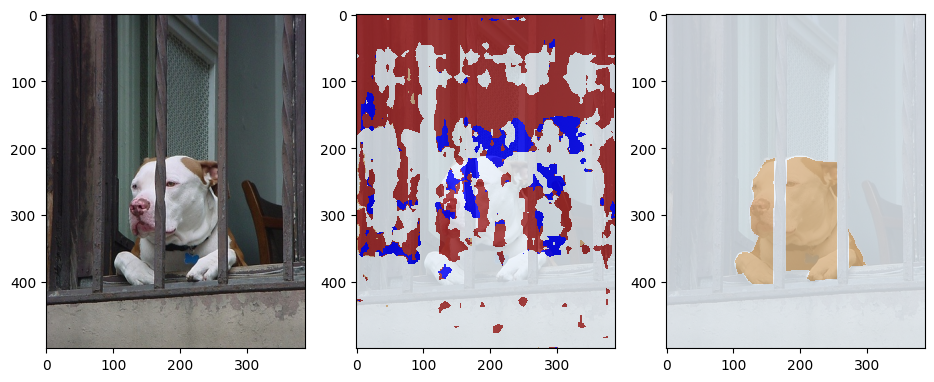

prediction num: [ 0  9 11 12 15]
prediction color: ['background', 'chair', 'diningtable', 'dog', 'person']
prediction class: ['aliceblue', 'blue', 'brown', 'burlywood', 'tan']
groundtruth num: [ 0 12]
groundtruth color: ['background', 'dog']
groundtruth class: ['aliceblue', 'burlywood']


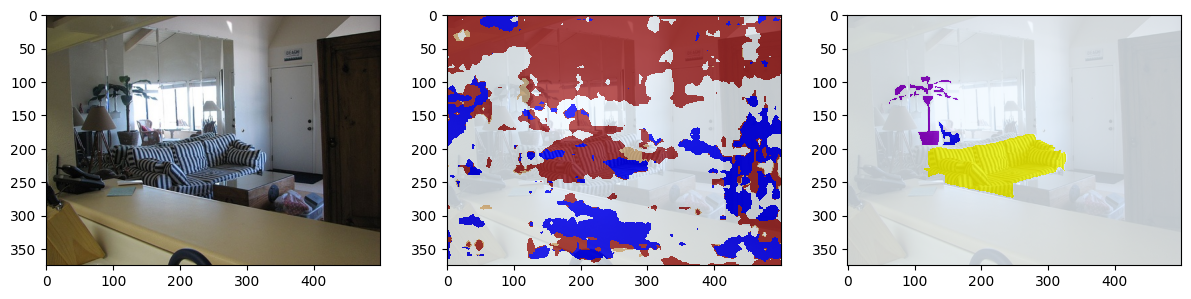

prediction num: [ 0  9 11 12 15]
prediction color: ['background', 'chair', 'diningtable', 'dog', 'person']
prediction class: ['aliceblue', 'blue', 'brown', 'burlywood', 'tan']
groundtruth num: [ 0  9 16 18]
groundtruth color: ['background', 'chair', 'pottedplant', 'sofa']
groundtruth class: ['aliceblue', 'blue', 'darkviolet', 'yellow']


In [10]:
# test 2
cfg = edict({
    "batch_size": 1, # 批大小
    "crop_size": 513, # 图像裁剪大小
    "image_mean": [103.53, 116.28, 123.675], # RGB图像为3通道，定义图像RGB均值
    "image_std": [57.375, 57.120, 58.395], # RGB图像为3通道，定义图像RGB标准差
    "scales": [1.0], # 数据增强的尺度范围
    # [0.5,0.75,1.0,1.25,1.75]
    'flip': True, # 是否进行翻转
    'ignore_label': 255, # 忽略标签的像素值
    'num_classes':21, # 类别数，此处为PASCAL VOC数据集
    'model': 'deeplab_v3_s8', # 模型名称
    'freeze_bn': True, # BN冻结，是否使用BN层

    'if_png':True,         # 图像数据是否使用png格式
    'num_png':3            # png图像数量
})



# import moxing as mox
data_path = './seg2'
# if not os.path.exists(data_path):
#     mox.file.copy_parallel(src_url="s3://share-course/dataset/voc2012_raw/", dst_url=data_path)
# 数据集路径
cfg.data_file = data_path

# 定义数据集
dataset = SegDataset(image_mean=cfg.image_mean,
                                    image_std=cfg.image_std,
                                    data_file=cfg.data_file)
dataset.get_gray_dataset()
# 数据集的txt标签路径
cfg.data_lst = os.path.join(cfg.data_file,'val.txt')
# VOC数据集中的图像路径
cfg.voc_img_dir = os.path.join(cfg.data_file,'JPEG')
# VOC数据集中的标签图像路径
cfg.voc_anno_gray_dir = os.path.join(cfg.data_file,'SegmentationClassGray')

ckpt_path = './ckpt'
# if not os.path.exists(ckpt_path):
#     mox.file.copy_parallel(src_url="s3://yyq-3/DATA/code/deeplabv3/model", dst_url=ckpt_path)     #if yours model had saved
cfg.ckpt_file = os.path.join(ckpt_path,'deeplab_v3_s8-300_11.ckpt') \
# 加载模型文件路径 
print('loading checkpoing:',cfg.ckpt_file)
# 模型验证评估
net_eval(cfg)